# Chapter 6 - Apply models to idiopathic participants

## Setup

Run Python file to import libraries and custom functions

In [1]:
%run libraries.py

/Users/joefarrington/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/joefarrington/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Set paths for data and models

In [2]:
data_path = '/Users/joefarrington/Documents/MSc Machine Learning/Project/August/Data for import/'
results_path = '/Users/joefarrington/Documents/MSc Machine Learning/Project/August/Results/Ch6idio/'

Define a string to be added to the name of all saved results from this notebook

In [9]:
nbname = 'Ch6idio'

Import the data for the Bruining dataset

In [10]:
X_syn_B = pd.read_csv(data_path+'X_all_B.csv', index_col=0)
y_syn_B = np.array(pd.read_csv(data_path+'y_all_B.csv', index_col=0, header=None)).reshape(-1,)

Import the data for all the syndromic participants

In [11]:
X_syn_all = pd.read_csv(data_path+'X_all_Rev.csv', index_col=0)
y_syn_all = np.array(pd.read_csv(data_path+'y_all_Rev.csv', index_col=0, header=None)).reshape(-1,)

Import the data for the idiopathic participants

In [6]:
X_idio_all = pd.read_csv(data_path+'X_idio_all.csv', index_col=0)

Define an sklearn scorer object to calculate the Matthews Correlation Coefficient (MCC)

In [7]:
mcc_scorer = make_scorer(matthews_corrcoef)

Function to train models on syndromic and predict on idiopathic

In [13]:
def train_syn_pred_idio(X_B, y_B, X_Rev, y_Rev, X_idio, n_folds, param_grid, model, scorer, verbose):
    
    #For Bruining
    skf_B = StratifiedKFold(n_splits=n_folds)
    gs_B = GridSearchCV(model, param_grid, cv=skf_B, iid=False, scoring=scorer, n_jobs=-1, verbose=verbose)
    gs_B.fit(X_B, y_B)
    ypreds_B = gs_B.predict(X_idio)
    
    #For whole syndromic dataset
    skf_Rev = StratifiedKFold(n_splits=n_folds)
    gs_Rev = GridSearchCV(model, param_grid, cv=skf_Rev, iid=False, scoring=scorer, n_jobs=-1, verbose=verbose)
    gs_Rev.fit(X_Rev, y_Rev)
    ypreds_Rev = gs_Rev.predict(X_idio)
    
    #Produce dataframe that compares predictions
    
    
    B_labels = np.unique(y_B)
    nclasses_B = len(B_labels)
    
    Rev_labels = np.unique(y_Rev)
    nclasses_Rev = len(Rev_labels)

    res_df = pd.DataFrame(np.zeros((nclasses_B, nclasses_Rev)), index = B_labels, columns = Rev_labels)
    
    for i in range(0, len(ypreds_Rev)):
        r = ypreds_B[i]
        c = ypreds_Rev[i]
        res_df.loc[r,c] += 1
    
    #Return a dictionary with the results
    res_dict = {'model_B': gs_B, 'model_Rev': gs_Rev, 'ypreds_B':ypreds_B, 'ypreds_Rev':ypreds_Rev, 'res_df':res_df}
    
    print(res_df)
    
    return res_dict
    

## Model 1: OvO SVM with RBF kernel

Define the number of folds for cross-validation

In [9]:
n_folds = 10

Define the model

In [10]:
svc_rbf = SVC(decision_function_shape='ovo', kernel='rbf')
steps_rbf = [('scaler', StandardScaler()),
     ('model',svc_rbf)]
pipeline_rbf = Pipeline(steps_rbf)

Define the parameters for the grid seach

In [11]:
rbf_C_range = np.logspace(start=-5, stop=15, num=21, base=2)
rbf_gamma_range = np.logspace(start=-15, stop=3, num=19, base=2)
rbf_parameters = dict(model__gamma=rbf_gamma_range, model__C=rbf_C_range)

Run the training and prediction

In [14]:
rbf_svm_resdict = train_syn_pred_idio(X_B = X_syn_B, y_B = y_syn_B, X_Rev = X_syn_all, y_Rev = y_syn_all, 
                                           X_idio = X_idio_all, n_folds = n_folds, param_grid = rbf_parameters,
                                           model = pipeline_rbf, scorer = mcc_scorer, verbose =1)

Fitting 10 folds for each of 399 candidates, totalling 3990 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 2704 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 3990 out of 3990 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 399 candidates, totalling 3990 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 3975 out of 3990 | elapsed:   47.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 3990 out of 3990 | elapsed:   47.6s finished


         22q11DS  Down  FXS-F  FXS-M  NF1  PW-UPD  PW-del  SMC15   TSC  XXY
22q11DS     31.0   1.0    3.0    9.0  3.0     0.0     0.0    0.0  34.0  1.0
Down         0.0   2.0    0.0    0.0  0.0     0.0     0.0    0.0   7.0  0.0
PW           1.0   0.0    1.0    1.0  0.0     3.0     3.0    0.0   7.0  0.0
SMC15        0.0   0.0    0.0    2.0  0.0     0.0     0.0    0.0   0.0  0.0
TSC          1.0   0.0    4.0   18.0  7.0     0.0     0.0    0.0  60.0  0.0
XXY          3.0   0.0    2.0    7.0  4.0     0.0     0.0    0.0  33.0  3.0


Save the results

In [16]:
pickle.dump(rbf_svm_resdict, open(results_path+f"rbf_svm_resdict.p", "wb" ))

Load the results

In [45]:
rbf_svm_dict = pickle.load(open(results_path+f"rbf_svm_resdict.p", "rb" ))

Print the dataframe (normalized)

In [47]:
rbf_svm_dict['res_df']/251

,22q11DS,Down,FXS-F,FXS-M,NF1,PW-UPD,PW-del,SMC15,TSC,XXY
22q11DS,0.123506,0.003984,0.011952,0.035857,0.011952,0.000000,0.000000,0.0,0.135458,0.003984
Down,0.000000,0.007968,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.027888,0.000000
PW,0.003984,0.000000,0.003984,0.003984,0.000000,0.011952,0.011952,0.0,0.027888,0.000000
SMC15,0.000000,0.000000,0.000000,0.007968,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
TSC,0.003984,0.000000,0.015936,0.071713,0.027888,0.000000,0.000000,0.0,0.239044,0.000000
XXY,0.011952,0.000000,0.007968,0.027888,0.015936,0.000000,0.000000,0.0,0.131474,0.011952


Print the proportions assigned to each class

In [23]:
pd.Series(rbf_svm_resdict['ypreds_B']).value_counts()/251

TSC        0.358566
22q11DS    0.326693
XXY        0.207171
PW         0.063745
Down       0.035857
SMC15      0.007968
dtype: float64

In [24]:
pd.Series(rbf_svm_resdict['ypreds_Rev']).value_counts()/251

TSC        0.561753
FXS-M      0.147410
22q11DS    0.143426
NF1        0.055777
FXS-F      0.039841
XXY        0.015936
PW-del     0.011952
Down       0.011952
PW-UPD     0.011952
dtype: float64

Plot a figure for the results

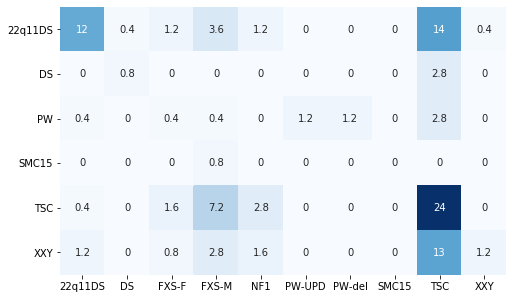

In [26]:
fig, ax = plt.subplots(figsize=(8,16))
sns.heatmap((rbf_svm_resdict['res_df']), cmap='Blues', annot = (rbf_svm_resdict['res_df'])/2.51, 
            square=True, cbar=False, ax=ax);

B_labels = np.unique(y_syn_B);
B_labels[1] = 'DS';

Rev_labels = np.unique(y_syn_all);
Rev_labels[1] = 'DS';

ax.set_xticklabels(Rev_labels);
ax.set_yticklabels(B_labels);

## Model 2: OvO SVM with linear kernel

Define the number of folds for cross-validation

In [27]:
n_folds = 10

Define the model

In [28]:
svc_lin = SVC(decision_function_shape='ovo', kernel='linear')
steps_lin = [('scaler', StandardScaler()),
     ('model',svc_lin)]
pipeline_lin = Pipeline(steps_lin)

Define the parameters for the grid seach

In [29]:
lin_C_range = np.logspace(start=-10, stop=10, num=21, base=2)
lin_parameters = dict(model__C=lin_C_range)

Run the training and prediction

In [32]:
lin_svm_resdict = train_syn_pred_idio(X_B = X_syn_B, y_B = y_syn_B, X_Rev = X_syn_all, y_Rev = y_syn_all, 
                                           X_idio = X_idio_all, n_folds = n_folds, param_grid = lin_parameters,
                                           model = pipeline_lin, scorer = mcc_scorer, verbose =1)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 21 candidates, totalling 210 fits
         22q11DS  Down  FXS-F  FXS-M  NF1  PW-UPD  PW-del  SMC15   TSC  XXY
22q11DS     17.0   1.0    3.0   10.0  1.0     0.0     0.0    0.0  36.0  0.0
Down         0.0   0.0    0.0    0.0  0.0     0.0     0.0    0.0   0.0  0.0
PW          16.0   4.0    1.0    0.0  0.0     3.0     6.0    0.0  25.0  3.0
SMC15        0.0   0.0    0.0    2.0  2.0     0.0     0.0    1.0   3.0  0.0
TSC          0.0   0.0    4.0   14.0  4.0     0.0     0.0    1.0  53.0  0.0
XXY          0.0   0.0    3.0    4.0  6.0     0.0     0.0    0.0  22.0  6.0


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  4.2min finished


Save the results

In [33]:
pickle.dump(lin_svm_resdict, open(results_path+f"lin_svm_resdict.p", "wb" ))

Load the results

In [48]:
lin_svm_dict = pickle.load(open(results_path+f"lin_svm_resdict.p", "rb" ))

Print the dataframe (normalized)

In [50]:
lin_svm_dict['res_df']/251

,22q11DS,Down,FXS-F,FXS-M,NF1,PW-UPD,PW-del,SMC15,TSC,XXY
22q11DS,0.067729,0.003984,0.011952,0.039841,0.003984,0.000000,0.000000,0.000000,0.143426,0.000000
Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PW,0.063745,0.015936,0.003984,0.000000,0.000000,0.011952,0.023904,0.000000,0.099602,0.011952
SMC15,0.000000,0.000000,0.000000,0.007968,0.007968,0.000000,0.000000,0.003984,0.011952,0.000000
TSC,0.000000,0.000000,0.015936,0.055777,0.015936,0.000000,0.000000,0.003984,0.211155,0.000000
XXY,0.000000,0.000000,0.011952,0.015936,0.023904,0.000000,0.000000,0.000000,0.087649,0.023904


Print the proportions assigned to each class

In [35]:
pd.Series(lin_svm_resdict['ypreds_B']).value_counts()/251

TSC        0.302789
22q11DS    0.270916
PW         0.231076
XXY        0.163347
SMC15      0.031873
dtype: float64

In [36]:
pd.Series(lin_svm_resdict['ypreds_Rev']).value_counts()/251

TSC        0.553785
22q11DS    0.131474
FXS-M      0.119522
NF1        0.051793
FXS-F      0.043825
XXY        0.035857
PW-del     0.023904
Down       0.019920
PW-UPD     0.011952
SMC15      0.007968
dtype: float64

Plot a figure for the results

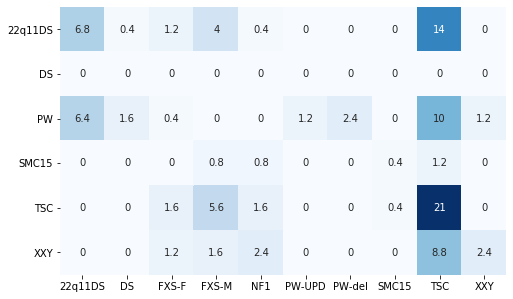

In [38]:
fig, ax = plt.subplots(figsize=(8,16))
sns.heatmap((lin_svm_resdict['res_df']), cmap='Blues', annot = (lin_svm_resdict['res_df'])/2.51, 
            square=True, cbar=False, ax=ax);

B_labels = np.unique(y_syn_B);
B_labels[1] = 'DS';

Rev_labels = np.unique(y_syn_all);
Rev_labels[1] = 'DS';

ax.set_xticklabels(Rev_labels);
ax.set_yticklabels(B_labels);

## Model 3: Naive Bayes (learn prior)

See <b>Naive Bayes in R.ipynb</b>

Load in the results

In [4]:
nb_noprior_res = pd.read_csv(results_path+'nb_idio_noprior_res.csv', index_col=0)

Print the proportions assigned to each class

In [6]:
nb_noprior_res['ypreds_B'].value_counts()/251

PW         0.290837
SMC15      0.258964
TSC        0.191235
22q11DS    0.147410
XXY        0.107570
Down       0.003984
Name: ypreds_B, dtype: float64

In [7]:
nb_noprior_res['ypreds_Rev'].value_counts()/251

FXS-M      0.294821
PW-del     0.179283
Down       0.127490
TSC        0.099602
SMC15      0.071713
22q11DS    0.067729
NF1        0.059761
FXS-F      0.059761
XXY        0.039841
Name: ypreds_Rev, dtype: float64

Produce a dataframe comparing the predictions

In [14]:
B_labels = np.unique(y_syn_B)
nclasses_B = len(B_labels)

Rev_labels = np.unique(y_syn_all)
nclasses_Rev = len(Rev_labels)

In [15]:
nb_noprior_res_df = pd.DataFrame(np.zeros((nclasses_B, nclasses_Rev)), index = B_labels, columns = Rev_labels)

In [23]:
ypreds_B = np.array(nb_noprior_res['ypreds_B'])
ypreds_Rev = np.array(nb_noprior_res['ypreds_Rev'])

for i in range(0, len(ypreds_Rev)):
    r = ypreds_B[i]
    c = ypreds_Rev[i]
    nb_noprior_res_df.loc[r,c] += 1

Print the dataframe (normalized)

In [44]:
nb_noprior_res_df/251

,22q11DS,Down,FXS-F,FXS-M,NF1,PW-UPD,PW-del,SMC15,TSC,XXY
22q11DS,0.059761,0.015936,0.027888,0.019920,0.007968,0.0,0.003984,0.000000,0.011952,0.000000
Down,0.000000,0.003984,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
PW,0.003984,0.099602,0.007968,0.000000,0.000000,0.0,0.175299,0.000000,0.000000,0.003984
SMC15,0.000000,0.000000,0.000000,0.163347,0.023904,0.0,0.000000,0.071713,0.000000,0.000000
TSC,0.003984,0.000000,0.000000,0.091633,0.019920,0.0,0.000000,0.000000,0.075697,0.000000
XXY,0.000000,0.007968,0.023904,0.019920,0.007968,0.0,0.000000,0.000000,0.011952,0.035857


Plot a figure with the results

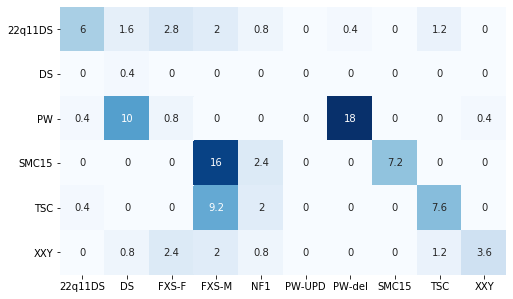

In [25]:
fig, ax = plt.subplots(figsize=(8,16))
sns.heatmap(nb_noprior_res_df, cmap='Blues', annot = nb_noprior_res_df/2.51, 
            square=True, cbar=False, ax=ax);

B_labels = np.unique(y_syn_B);
B_labels[1] = 'DS';

Rev_labels = np.unique(y_syn_all);
Rev_labels[1] = 'DS';

ax.set_xticklabels(Rev_labels);
ax.set_yticklabels(B_labels);

## Model 4: Naive Bayes (uniform prior)

See <b>Naive Bayes in R.ipynb</b>

Load in the results

In [26]:
nb_uniprior_res = pd.read_csv(results_path+'nb_idio_uniprior_res.csv', index_col=0)

Print the proportions assigned to each class

In [27]:
nb_uniprior_res['ypreds_B'].value_counts()/251

SMC15      0.290837
PW         0.270916
TSC        0.183267
XXY        0.127490
22q11DS    0.091633
Down       0.035857
Name: ypreds_B, dtype: float64

In [28]:
nb_uniprior_res['ypreds_Rev'].value_counts()/251

FXS-M      0.247012
PW-del     0.183267
Down       0.151394
NF1        0.123506
SMC15      0.095618
FXS-F      0.063745
22q11DS    0.051793
TSC        0.043825
XXY        0.039841
Name: ypreds_Rev, dtype: float64

Produce a dataframe comparing the predictions

In [29]:
B_labels = np.unique(y_syn_B)
nclasses_B = len(B_labels)

Rev_labels = np.unique(y_syn_all)
nclasses_Rev = len(Rev_labels)

In [30]:
nb_uniprior_res_df = pd.DataFrame(np.zeros((nclasses_B, nclasses_Rev)), index = B_labels, columns = Rev_labels)

In [31]:
ypreds_B = np.array(nb_uniprior_res['ypreds_B'])
ypreds_Rev = np.array(nb_uniprior_res['ypreds_Rev'])

for i in range(0, len(ypreds_Rev)):
    r = ypreds_B[i]
    c = ypreds_Rev[i]
    nb_uniprior_res_df.loc[r,c] += 1

Print the dataframe (normalized)

In [43]:
nb_uniprior_res_df/251

,22q11DS,Down,FXS-F,FXS-M,NF1,PW-UPD,PW-del,SMC15,TSC,XXY
22q11DS,0.047809,0.007968,0.011952,0.011952,0.007968,0.0,0.003984,0.000000,0.000000,0.000000
Down,0.000000,0.027888,0.007968,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
PW,0.000000,0.099602,0.000000,0.000000,0.000000,0.0,0.171315,0.000000,0.000000,0.000000
SMC15,0.000000,0.000000,0.000000,0.151394,0.043825,0.0,0.000000,0.095618,0.000000,0.000000
TSC,0.003984,0.003984,0.007968,0.071713,0.063745,0.0,0.000000,0.000000,0.031873,0.000000
XXY,0.000000,0.011952,0.035857,0.011952,0.007968,0.0,0.007968,0.000000,0.011952,0.039841


Plot a figure with the results

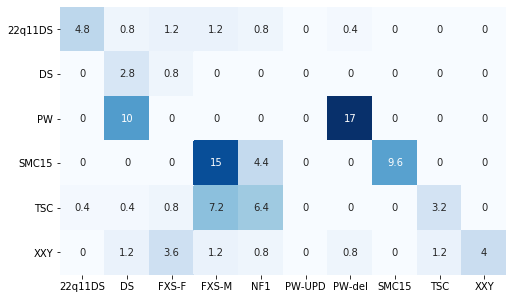

In [32]:
fig, ax = plt.subplots(figsize=(8,16))
sns.heatmap(nb_uniprior_res_df, cmap='Blues', annot = nb_uniprior_res_df/2.51, 
            square=True, cbar=False, ax=ax);

B_labels = np.unique(y_syn_B);
B_labels[1] = 'DS';

Rev_labels = np.unique(y_syn_all);
Rev_labels[1] = 'DS';

ax.set_xticklabels(Rev_labels);
ax.set_yticklabels(B_labels);

## Model 5 : Standard Random Forest

Define the number of folds for cross-validation

In [39]:
n_folds = 10

Define the model

In [40]:
rfc_naive = RandomForestClassifier()

Define the parameters for the grid seach

In [41]:
n_features = X_syn_B.shape[1]
default_mtry = np.sqrt(n_features)
rfc_parameters = {'max_features': [int(0.5*default_mtry), int(default_mtry), int(1.5*default_mtry), int(2*default_mtry), int(3*default_mtry)],
             'n_estimators': [2000], 'min_samples_leaf': [1,2, 3, 4, 5]}

Run the training and prediction

In [42]:
rfc_naive_resdict = train_syn_pred_idio(X_B = X_syn_B, y_B = y_syn_B, X_Rev = X_syn_all, y_Rev = y_syn_all, 
                                           X_idio = X_idio_all, n_folds = n_folds, param_grid = rfc_parameters,
                                           model = rfc_naive, scorer = mcc_scorer, verbose =1)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/joefarrington/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.4min finished


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
/Users/joefarrington/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.1min finished


         22q11DS  Down  FXS-F  FXS-M  NF1  PW-UPD  PW-del  SMC15   TSC  XXY
22q11DS     30.0   2.0    6.0   18.0  0.0     0.0     0.0    1.0  51.0  4.0
Down         0.0   0.0    0.0    0.0  0.0     0.0     0.0    0.0   1.0  0.0
PW           4.0   8.0    4.0    1.0  0.0     4.0     4.0    0.0  14.0  1.0
SMC15        0.0   0.0    0.0    0.0  0.0     0.0     0.0    0.0   1.0  0.0
TSC          1.0   0.0    0.0   16.0  5.0     0.0     0.0    2.0  56.0  1.0
XXY          0.0   0.0    0.0    2.0  1.0     0.0     0.0    0.0  10.0  3.0


Save the results

In [44]:
pickle.dump(rfc_weighted_resdict, open(results_path+f"rfc_naive_resdict.p", "wb" ))

Load the results

In [51]:
rfc_naive_resdict = pickle.load(open(results_path+f"rfc_naive_resdict.p", "rb" ))

Print the dataframe (normalized)

In [53]:
rfc_naive_resdict['res_df']/251

,22q11DS,Down,FXS-F,FXS-M,NF1,PW-UPD,PW-del,SMC15,TSC,XXY
22q11DS,0.119522,0.007968,0.023904,0.071713,0.000000,0.000000,0.000000,0.003984,0.203187,0.015936
Down,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003984,0.000000
PW,0.015936,0.031873,0.015936,0.003984,0.000000,0.015936,0.015936,0.000000,0.055777,0.003984
SMC15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003984,0.000000
TSC,0.003984,0.000000,0.000000,0.063745,0.019920,0.000000,0.000000,0.007968,0.223108,0.003984
XXY,0.000000,0.000000,0.000000,0.007968,0.003984,0.000000,0.000000,0.000000,0.039841,0.011952


Print the proportions assigned to each class

In [46]:
pd.Series(rfc_naive_resdict['ypreds_B']).value_counts()/251

22q11DS    0.446215
TSC        0.322709
PW         0.159363
XXY        0.063745
SMC15      0.003984
Down       0.003984
dtype: float64

In [47]:
pd.Series(rfc_naive_resdict['ypreds_Rev']).value_counts()/251

TSC        0.529880
FXS-M      0.147410
22q11DS    0.139442
FXS-F      0.039841
Down       0.039841
XXY        0.035857
NF1        0.023904
PW-del     0.015936
PW-UPD     0.015936
SMC15      0.011952
dtype: float64

Plot a figure for the results

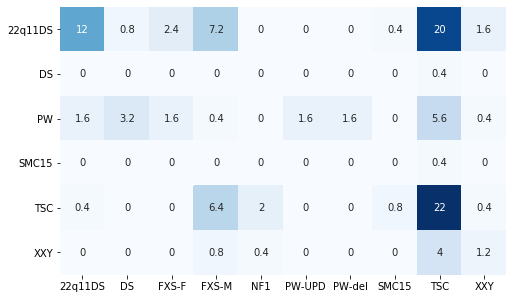

In [49]:
fig, ax = plt.subplots(figsize=(8,16))
sns.heatmap((rfc_naive_resdict['res_df']), cmap='Blues', annot = (rfc_naive_resdict['res_df'])/2.51, 
            square=True, cbar=False, ax=ax);

B_labels = np.unique(y_syn_B);
B_labels[1] = 'DS';

Rev_labels = np.unique(y_syn_all);
Rev_labels[1] = 'DS';

ax.set_xticklabels(Rev_labels);
ax.set_yticklabels(B_labels);

## Model 6 : Balanced Random Forest

Define the number of folds for cross-validation

In [50]:
n_folds = 10

Define the model

In [51]:
rfc_bal = BalancedRandomForestClassifier()

Define the parameters for the grid seach

In [52]:
n_features = X_syn_B.shape[1]
default_mtry = np.sqrt(n_features)
rfc_parameters = {'max_features': [int(0.5*default_mtry), int(default_mtry), int(1.5*default_mtry), int(2*default_mtry), int(3*default_mtry)],
             'n_estimators': [2000], 'min_samples_leaf': [1,2, 3, 4, 5]}

Run the training and prediction

In [53]:
rfc_bal_resdict = train_syn_pred_idio(X_B = X_syn_B, y_B = y_syn_B, X_Rev = X_syn_all, y_Rev = y_syn_all, 
                                           X_idio = X_idio_all, n_folds = n_folds, param_grid = rfc_parameters,
                                           model = rfc_bal, scorer = mcc_scorer, verbose =1)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.5s
/Users/joefarrington/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.4min finished


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/joefarrington/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  7.4min finished


         22q11DS  Down  FXS-F  FXS-M   NF1  PW-UPD  PW-del  SMC15   TSC  XXY
22q11DS     12.0   1.0   14.0    4.0   9.0     0.0     0.0    0.0   2.0  1.0
Down         1.0  14.0    3.0    0.0   2.0     1.0     0.0    0.0   0.0  3.0
PW           1.0  12.0   18.0    0.0   0.0     3.0     4.0    0.0   0.0  0.0
SMC15        0.0   0.0    2.0   14.0  15.0     0.0     0.0    9.0   5.0  0.0
TSC          2.0   2.0    6.0   26.0  25.0     0.0     2.0    1.0  11.0  2.0
XXY          0.0   0.0    6.0    4.0   3.0     0.0     0.0    0.0   2.0  9.0


Save the results

In [54]:
pickle.dump(rfc_bal_resdict, open(results_path+f"rfc_bal_resdict.p", "wb" ))

Load the results

In [54]:
rfc_bal_resdict = pickle.load(open(results_path+f"rfc_bal_resdict.p", "rb" ))

Print the dataframe (normalized)

In [55]:
rfc_bal_resdict['res_df']/251

,22q11DS,Down,FXS-F,FXS-M,NF1,PW-UPD,PW-del,SMC15,TSC,XXY
22q11DS,0.047809,0.003984,0.055777,0.015936,0.035857,0.000000,0.000000,0.000000,0.007968,0.003984
Down,0.003984,0.055777,0.011952,0.000000,0.007968,0.003984,0.000000,0.000000,0.000000,0.011952
PW,0.003984,0.047809,0.071713,0.000000,0.000000,0.011952,0.015936,0.000000,0.000000,0.000000
SMC15,0.000000,0.000000,0.007968,0.055777,0.059761,0.000000,0.000000,0.035857,0.019920,0.000000
TSC,0.007968,0.007968,0.023904,0.103586,0.099602,0.000000,0.007968,0.003984,0.043825,0.007968
XXY,0.000000,0.000000,0.023904,0.015936,0.011952,0.000000,0.000000,0.000000,0.007968,0.035857


Print the proportions assigned to each class

In [56]:
pd.Series(rfc_bal_resdict['ypreds_B']).value_counts()/251

TSC        0.306773
SMC15      0.179283
22q11DS    0.171315
PW         0.151394
XXY        0.095618
Down       0.095618
dtype: float64

In [57]:
pd.Series(rfc_bal_resdict['ypreds_Rev']).value_counts()/251

NF1        0.215139
FXS-F      0.195219
FXS-M      0.191235
Down       0.115538
TSC        0.079681
22q11DS    0.063745
XXY        0.059761
SMC15      0.039841
PW-del     0.023904
PW-UPD     0.015936
dtype: float64

Plot a figure for the results

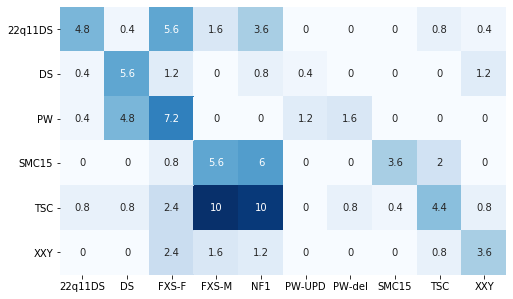

In [59]:
fig, ax = plt.subplots(figsize=(8,16))
sns.heatmap((rfc_bal_resdict['res_df']), cmap='Blues', annot = (rfc_bal_resdict['res_df'])/2.51, 
            square=True, cbar=False, ax=ax);

B_labels = np.unique(y_syn_B);
B_labels[1] = 'DS';

Rev_labels = np.unique(y_syn_all);
Rev_labels[1] = 'DS';

ax.set_xticklabels(Rev_labels);
ax.set_yticklabels(B_labels);

## Model 7: Weighted Random Forest

Define the number of folds for cross-validation

In [60]:
n_folds = 10

Define the model

In [61]:
rfc_weighted = RandomForestClassifier(class_weight = 'balanced_subsample')

Define the parameters for the grid seach

In [62]:
n_features = X_syn_B.shape[1]
default_mtry = np.sqrt(n_features)
rfc_parameters = {'max_features': [int(0.5*default_mtry), int(default_mtry), int(1.5*default_mtry), int(2*default_mtry), int(3*default_mtry)],
             'n_estimators': [2000], 'min_samples_leaf': [1,2, 3, 4, 5]}

Run the training and prediction

In [63]:
rfc_weighted_resdict = train_syn_pred_idio(X_B = X_syn_B, y_B = y_syn_B, X_Rev = X_syn_all, y_Rev = y_syn_all, 
                                           X_idio = X_idio_all, n_folds = n_folds, param_grid = rfc_parameters,
                                           model = rfc_weighted, scorer = mcc_scorer, verbose =1)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  2.8min finished


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.8min finished


         22q11DS  Down  FXS-F  FXS-M   NF1  PW-UPD  PW-del  SMC15   TSC  XXY
22q11DS     18.0   7.0   11.0   25.0   6.0     0.0     0.0    1.0  17.0  2.0
Down         0.0   2.0    0.0    0.0   0.0     0.0     0.0    0.0   0.0  0.0
PW           0.0  28.0    6.0    0.0   0.0     2.0     6.0    0.0   2.0  0.0
SMC15        0.0   0.0    0.0    1.0   0.0     0.0     0.0    0.0   0.0  0.0
TSC          2.0   3.0    4.0   29.0  13.0     0.0     2.0    7.0  29.0  1.0
XXY          0.0   0.0    2.0    8.0   2.0     1.0     1.0    0.0   7.0  6.0


Save the results

In [69]:
pickle.dump(rfc_weighted_resdict, open(results_path+f"rfc_weighted_resdict.p", "wb" ))

Load the results

In [35]:
rfc_weighted_resdict = pickle.load(open(results_path+f"rfc_weighted_resdict.p", "rb" ))

Print the dataframe (normalized)

In [56]:
rfc_weighted_resdict['res_df']/251

,22q11DS,Down,FXS-F,FXS-M,NF1,PW-UPD,PW-del,SMC15,TSC,XXY
22q11DS,0.071713,0.027888,0.043825,0.099602,0.023904,0.000000,0.000000,0.003984,0.067729,0.007968
Down,0.000000,0.007968,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PW,0.000000,0.111554,0.023904,0.000000,0.000000,0.007968,0.023904,0.000000,0.007968,0.000000
SMC15,0.000000,0.000000,0.000000,0.003984,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TSC,0.007968,0.011952,0.015936,0.115538,0.051793,0.000000,0.007968,0.027888,0.115538,0.003984
XXY,0.000000,0.000000,0.007968,0.031873,0.007968,0.003984,0.003984,0.000000,0.027888,0.023904


Print the proportions assigned to each class

In [71]:
pd.Series(rfc_weighted_resdict['ypreds_B']).value_counts()/251

TSC        0.358566
22q11DS    0.346614
PW         0.175299
XXY        0.107570
Down       0.007968
SMC15      0.003984
dtype: float64

In [72]:
pd.Series(rfc_weighted_resdict['ypreds_Rev']).value_counts()/251

FXS-M      0.250996
TSC        0.219124
Down       0.159363
FXS-F      0.091633
NF1        0.083665
22q11DS    0.079681
PW-del     0.035857
XXY        0.035857
SMC15      0.031873
PW-UPD     0.011952
dtype: float64

Plot a figure for the results

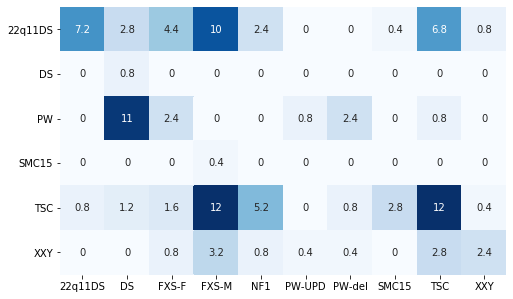

In [36]:
fig, ax = plt.subplots(figsize=(8,16))
sns.heatmap((rfc_weighted_resdict['res_df']), cmap='Blues', annot = (rfc_weighted_resdict['res_df'])/2.51, 
            square=True, cbar=False, ax=ax);

B_labels = np.unique(y_syn_B);
B_labels[1] = 'DS';

Rev_labels = np.unique(y_syn_all);
Rev_labels[1] = 'DS';

ax.set_xticklabels(Rev_labels);
ax.set_yticklabels(B_labels);